In [30]:
#AI gen 

In [1]:
# Install necessary packages
!pip install tensorflow
!pip install keras
!pip install datasets --quiet
!pip install -q datasets torchvision transformers
!pip install huggingface_hub
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 17.6 MB/s eta 0:00:00a 0:00:01


# 1. Setup and Data Loading

First, we install the Hugging Face datasets library (if not already available) to load the dataset directly. We also import PyTorch and other libraries for model building, training, and visualization. We'll ensure we have a GPU if available for faster training.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset


In [3]:
# Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Now, load the dataset from Hugging Face. The dataset is stored in the Hemg/AI-Generated-vs-Real-Images-Datasets repository and includes ~152k images with a binary label indicating AI-generated art (label 0) or Real image (label 1). We use the load_dataset function which downloads the data (about 1.37 GB) and prepares it for use.

In [4]:
# Load the dataset from Hugging Face
dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")
print(dataset)


README.md:   0%|          | 0.00/590 [00:00<?, ?B/s]

(…)-00000-of-00006-336b26d54a26e17a.parquet:   0%|          | 0.00/91.2M [00:00<?, ?B/s]

(…)-00001-of-00006-8ad2d550254dea81.parquet:   0%|          | 0.00/25.9M [00:00<?, ?B/s]

(…)-00002-of-00006-ac8970f21c0418c1.parquet:   0%|          | 0.00/339M [00:00<?, ?B/s]

(…)-00003-of-00006-f635132ef309a732.parquet:   0%|          | 0.00/311M [00:00<?, ?B/s]

(…)-00004-of-00006-1101eaf5152e1c5f.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

(…)-00005-of-00006-4bd152a5ab76dba7.parquet:   0%|          | 0.00/565M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})


By default, the dataset has a single split named "train" with ~152,710 images. We will split this into a training set and a validation set for our purposes. Explore the dataset structure: The dataset has two features:
image: the image data.


*   label: class label (0 = AI-generated art, 1 = Real image).\\



Let's examine a few samples and the label distribution:

In [5]:
# Check features and label names
features = dataset["train"].features
label_names = features["label"].names
print("Label names:", label_names)

Label names: ['AiArtData', 'RealArt']


In [6]:
# Calculate class distribution using a sample
labels = [example["label"] for example in dataset["train"].select(range(1000))]
ai_count = labels.count(0)
real_count = labels.count(1)
print(f"Sampled label counts -> AI-generated: {ai_count}, Real: {real_count}")


Sampled label counts -> AI-generated: 1000, Real: 0


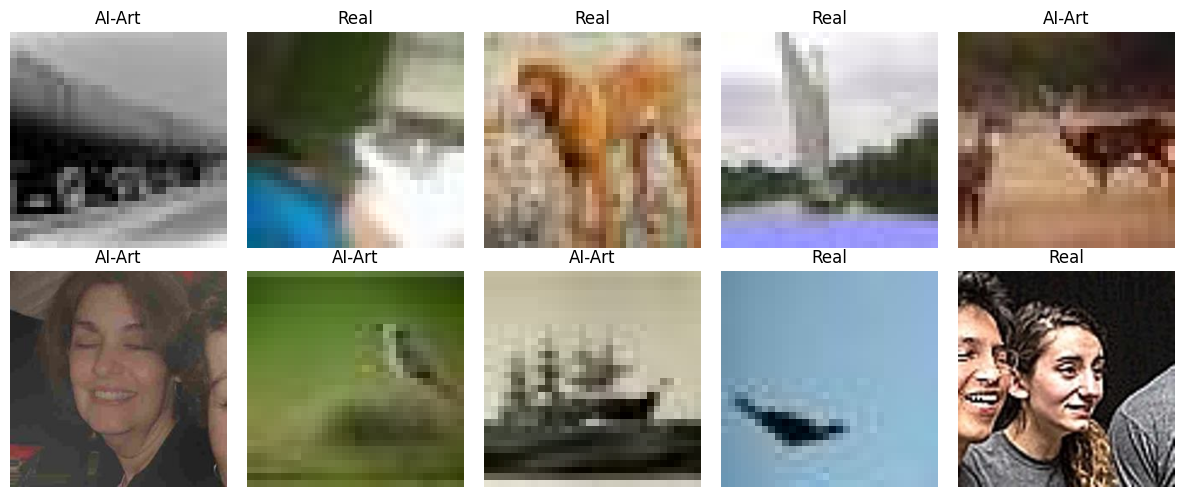

In [7]:
# Visualize a few examples
import matplotlib.pyplot as plt
examples = dataset["train"].shuffle(seed=42).select(range(10))
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, example in enumerate(examples):
    img = example["image"]
    label = example["label"]
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title("AI-Art" if label == 0 else "Real")
    ax.axis('off')
plt.tight_layout()
plt.show()


# 2. Data Preprocessing and Augmentation

In [8]:
# Split dataset into training and validation sets
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_ds = dataset["train"]
val_ds = dataset["test"]
print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

Training samples: 122168, Validation samples: 30542


## Define Helper Functions and Transforms

In [9]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torch

In [10]:


def ensure_pil(img):
    """
    Ensures the input is a PIL.Image.
    - If it's already a PIL image, returns it as-is.
    - If it's a torch.Tensor, converts it using to_pil_image.
    - If it's a np.ndarray, converts it using Image.fromarray.
    - If it's a list with exactly one element, recursively converts that element.
    - Otherwise, raises an error.
    """
    if isinstance(img, Image.Image):
        return img
    elif isinstance(img, torch.Tensor):
        return to_pil_image(img)
    elif isinstance(img, np.ndarray):
        return Image.fromarray(img.astype('uint8'))
    elif isinstance(img, list):
        if len(img) == 1:
            return ensure_pil(img[0])
        else:
            raise ValueError(f"Cannot convert list of length {len(img)} to PIL.")
    else:
        raise ValueError(f"Unsupported image type: {type(img)}")

In [11]:
def robust_transform(example, transform):
    """
    Applies the given transform to the "image" field in the example.
    Handles both individual examples and batched examples (i.e. when
    example["image"] is a list).
    """
    # If the image field is a list, process each image in the list.
    if isinstance(example["image"], list):
        new_images = []
        for img in example["image"]:
            img = ensure_pil(img)
            img = img.convert("RGB")
            new_images.append(transform(img))
        example["image"] = new_images
    else:
        img = ensure_pil(example["image"])
        img = img.convert("RGB")
        example["image"] = transform(img)
    return example



In [12]:
# Define base transforms (without forcing RGB conversion; that’s done in robust_transform)
img_size = 224

base_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
base_val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
# Define final transforms using our robust_transform function.
train_transform = lambda ex: robust_transform(ex, base_train_transforms)
val_transform = lambda ex: robust_transform(ex, base_val_transforms)


###  Verify Transform on a Sample

In [14]:
# # (Optional) Verify that a sample is correctly transformed
# # Use the processed training set (labeled_train) since that’s what you'll use for training.
# sample = labeled_train[0]
# transformed_sample = train_transform(sample)  # using the final transform lambda we defined earlier
# img_tensor = transformed_sample["image"]
# print("Transformed image type:", type(img_tensor))
# print("Transformed image shape:", img_tensor.shape)
# print("Expected output is torch.Tensor with shape [3, 224, 224]")


## Object Label Extraction using YOLO

In [19]:
def predict_obj_labels_yolo(batch):
    """
    Processes a batch of examples to generate aggregated object labels using YOLO.
    For each image, runs YOLO detection and aggregates detected class names 
    (deduplicated, comma-separated). If detection fails or an error occurs, returns "Unknown".
    """
    aggregated_labels = []
    for img in batch["image"]:
        try:
            if not isinstance(img, Image.Image):
                img = ensure_pil(img)
            if img.mode != "RGB":
                img = img.convert("RGB")
            np_img = np.array(img)
            results = yolo_model(np_img, verbose=False)
            class_names = []
            if results and results[0].boxes is not None:
                for det in results[0].boxes:
                    try:
                        cls_idx = int(det.cls.cpu().numpy())
                    except Exception as e:
                        print("Error converting detection class:", e)
                        continue
                    class_name = results[0].names[cls_idx]
                    class_names.append(class_name)
            if class_names:
                unique_labels = sorted(set(class_names))
                agg = ", ".join(unique_labels)
            else:
                agg = "Unknown"
        except ZeroDivisionError as zde:
            print("ZeroDivisionError encountered:", zde)
            agg = "Unknown"
        except Exception as e:
            print("Error processing an image:", e)
            agg = "Unknown"
        aggregated_labels.append(agg)
    batch["obj_label_str"] = aggregated_labels
    return batch


In [21]:
# # Process the entire training set using YOLO pseudo-labeling
# labeled_train = train_ds.map(predict_obj_labels_yolo, batched=True)
# # Build mapping from aggregated label strings to numeric indices
# unique_obj_labels = sorted(set(labeled_train["obj_label_str"]))
# obj_label_to_idx = {label: idx for idx, label in enumerate(unique_obj_labels)}
# print(f"Derived {len(unique_obj_labels)} unique object categories from YOLO detections.")

# # Add the numeric pseudo-label column
# labeled_train = labeled_train.add_column("obj_label", [obj_label_to_idx[label] for label in labeled_train["obj_label_str"]])


# Calculate 79% of the training set length
num_train_samples = int(0.79 * len(train_ds))
print("Processing first", num_train_samples, "samples out of", len(train_ds))

# Select only the first 79% of training samples
subset_train = train_ds.select(range(num_train_samples))

# Process the subset using YOLO pseudo-labeling
labeled_train = subset_train.map(predict_obj_labels_yolo, batched=True)

# Build mapping from aggregated label strings to numeric indices
unique_obj_labels = sorted(set(labeled_train["obj_label_str"]))
obj_label_to_idx = {label: idx for idx, label in enumerate(unique_obj_labels)}
print(f"Derived {len(unique_obj_labels)} unique object categories from YOLO detections.")

# Add the numeric pseudo-label column
labeled_train = labeled_train.add_column("obj_label", [obj_label_to_idx[label] for label in labeled_train["obj_label_str"]])


# Process the validation set similarly
labeled_val = val_ds.map(predict_obj_labels_yolo, batched=True)
val_indices = [i for i, label in enumerate(labeled_val["obj_label_str"]) if label in obj_label_to_idx]
labeled_val = labeled_val.select(val_indices)
labeled_val = labeled_val.add_column("obj_label", [obj_label_to_idx[label] for label in labeled_val["obj_label_str"]])
print(f"Validation set filtered size: {len(labeled_val)}")

Processing first 96512 samples out of 122168


Map:   0%|          | 0/96512 [00:00<?, ? examples/s]

<ipython-input-19-41953b407485>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls_idx = int(det.cls.cpu().numpy())


Derived 494 unique object categories from YOLO detections.


Map:   0%|          | 0/30542 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/30445 [00:00<?, ? examples/s]

Validation set filtered size: 30445


## Set Dataset Transforms

In [22]:
# Set transforms on processed datasets
labeled_train.set_transform(train_transform)
labeled_val.set_transform(val_transform)


In [23]:
# Verify that a sample from labeled_train is correctly transformed.
sample = labeled_train[0]
transformed_sample = train_transform(sample)
img_tensor = transformed_sample["image"]
print("Transformed image type:", type(img_tensor))
print("Transformed image shape:", img_tensor.shape)
print("Expected output is torch.Tensor with shape [3, 224, 224]")


Transformed image type: <class 'torch.Tensor'>
Transformed image shape: torch.Size([3, 224, 224])
Expected output is torch.Tensor with shape [3, 224, 224]


# 3. Multi-Task Model Architecture

In [24]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-50 and modify
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()
feature_dim = 2048

class MultiTaskModel(nn.Module):
    def __init__(self, backbone, feature_dim, num_obj_classes):
        super(MultiTaskModel, self).__init__()
        self.backbone = backbone
        self.obj_head = nn.Linear(feature_dim, num_obj_classes)
        self.bin_head = nn.Linear(feature_dim, 2)
    def forward(self, x):
        feats = self.backbone(x)
        obj_logits = self.obj_head(feats)
        bin_logits = self.bin_head(feats)
        return obj_logits, bin_logits

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s] 


In [25]:
num_obj_classes = len(unique_obj_labels)
model = MultiTaskModel(resnet, feature_dim, num_obj_classes).to(device)

# Create DataLoaders using default collate (transforms return proper tensors)
train_loader = DataLoader(labeled_train, batch_size=32, shuffle=True)
val_loader = DataLoader(labeled_val, batch_size=32, shuffle=False)

# 4. Training the Multi-Task Model

In [26]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

In [27]:

criterion_obj = nn.CrossEntropyLoss()
criterion_bin = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {"params": model.backbone.parameters(), "lr": 1e-4},
    {"params": model.obj_head.parameters(), "lr": 5e-4},
    {"params": model.bin_head.parameters(), "lr": 5e-4}
])

writer = SummaryWriter(log_dir="runs/multitask_experiment")


In [28]:
epochs = 35
patience = 7  # Increased patience for longer training
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        images = batch["image"].to(device)  # [B, 3, 224, 224]
        obj_labels = batch["obj_label"].to(device)
        bin_labels = batch["label"].to(device)
        optimizer.zero_grad()
        obj_logits, bin_logits = model(images)
        loss1 = criterion_obj(obj_logits, obj_labels)
        loss2 = criterion_bin(bin_logits, bin_labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    correct_obj = 0
    total_obj = 0
    correct_bin = 0
    total_bin = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            obj_labels = batch["obj_label"].to(device)
            bin_labels = batch["label"].to(device)
            obj_logits, bin_logits = model(images)
            loss1 = criterion_obj(obj_logits, obj_labels)
            loss2 = criterion_bin(bin_logits, bin_labels)
            loss = loss1 + loss2
            val_loss += loss.item()
            _, obj_preds = torch.max(obj_logits, dim=1)
            _, bin_preds = torch.max(bin_logits, dim=1)
            correct_obj += (obj_preds == obj_labels).sum().item()
            total_obj += obj_labels.size(0)
            correct_bin += (bin_preds == bin_labels).sum().item()
            total_bin += bin_labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_obj_acc = correct_obj / total_obj
    val_bin_acc = correct_bin / total_bin

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, " +
          f"Val Obj Acc = {val_obj_acc:.4f}, Val AI/Real Acc = {val_bin_acc:.4f}")
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Object", val_obj_acc, epoch)
    writer.add_scalar("Accuracy/RealVsAI", val_bin_acc, epoch)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Yolloplusclassproject_weights.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break



model.load_state_dict(torch.load("Yolloplusclassproject_weights.pth"))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss = 0.7837, Val Loss = 0.6508, Val Obj Acc = 0.8959, Val AI/Real Acc = 0.9404
Epoch 2: Train Loss = 0.6444, Val Loss = 0.6094, Val Obj Acc = 0.8961, Val AI/Real Acc = 0.9475
Epoch 3: Train Loss = 0.5899, Val Loss = 0.6144, Val Obj Acc = 0.8962, Val AI/Real Acc = 0.9460
Epoch 4: Train Loss = 0.5495, Val Loss = 0.5941, Val Obj Acc = 0.8960, Val AI/Real Acc = 0.9532
Epoch 5: Train Loss = 0.5141, Val Loss = 0.6199, Val Obj Acc = 0.8841, Val AI/Real Acc = 0.9556
Epoch 6: Train Loss = 0.4837, Val Loss = 0.5719, Val Obj Acc = 0.8955, Val AI/Real Acc = 0.9639
Epoch 7: Train Loss = 0.4531, Val Loss = 0.6016, Val Obj Acc = 0.8931, Val AI/Real Acc = 0.9595
Epoch 8: Train Loss = 0.4190, Val Loss = 0.5924, Val Obj Acc = 0.8971, Val AI/Real Acc = 0.9615
Epoch 9: Train Loss = 0.3888, Val Loss = 0.6142, Val Obj Acc = 0.8871, Val AI/Real Acc = 0.9645
Epoch 10: Train Loss = 0.3610, Val Loss = 0.6078, Val Obj Acc = 0.8928, Val AI/Real Acc = 0.9652
Epoch 11: Train Loss = 0.3350, Val Loss

<All keys matched successfully>

# 5. Evaluation and Sample Predictions

In [29]:
# Prepare label mappings for predictions.
idx_to_obj_label = {idx: label for label, idx in obj_label_to_idx.items()}
bin_label_names = ["AI-Generated", "Real"]

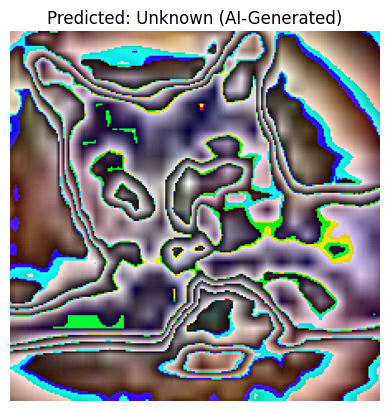

Model prediction: Unknown (AI-Generated)
Actual label: AI-Generated


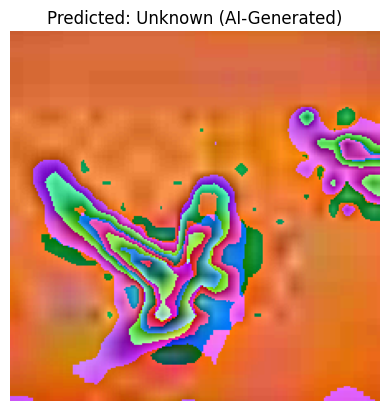

Model prediction: Unknown (AI-Generated)
Actual label: AI-Generated


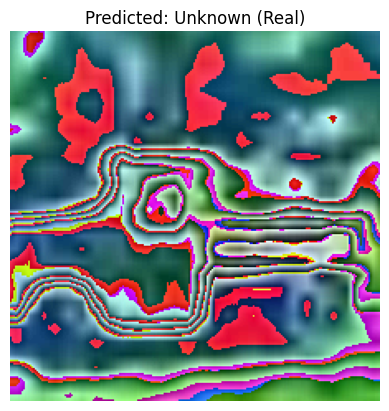

Model prediction: Unknown (Real)
Actual label: Real


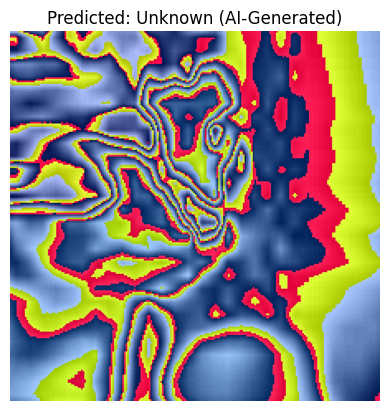

Model prediction: Unknown (AI-Generated)
Actual label: AI-Generated


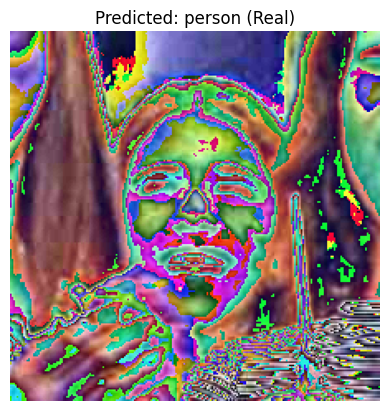

Model prediction: person (Real)
Actual label: Real


In [30]:
import random
model.eval()
samples = random.sample(range(len(labeled_val)), 5)
for idx in samples:
    example = labeled_val[idx]
    img = example["image"]
    img_tensor = img.unsqueeze(0).to(device)
    obj_logits, bin_logits = model(img_tensor)
    obj_pred = torch.argmax(obj_logits, dim=1).item()
    bin_pred = torch.argmax(bin_logits, dim=1).item()
    obj_name = idx_to_obj_label.get(obj_pred, "Unknown")
    bin_name = bin_label_names[bin_pred]
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.axis('off')
    plt.title(f"Predicted: {obj_name} ({bin_name})")
    plt.show()
    print(f"Model prediction: {obj_name} ({bin_name})")
    true_bin = "AI-Generated" if example["label"] == 0 else "Real"
    print(f"Actual label: {true_bin}")

# 6. Saving the Model

In [31]:
# Save the full model (architecture and weights).
torch.save(model, "Yolloplusclassproject.pth")
print("Full model saved as Yolloplusclassproject.pth")

Full model saved as Yolloplusclassproject.pth


In [32]:
# Save the model weights (state dict).
torch.save(model.state_dict(), "Yolloplusclassproject_weights.pth")
print("Model weights saved as Yolloplusclassproject_weights.pth")

Model weights saved as Yolloplusclassproject_weights.pth


In [ ]:
# # To reload later:
# model = torch.load("Yolloplusclassproject.pth")
# model.eval()
